In [6]:
import pandas as pd
import numpy as np
import re
import nltk
import spacy
import joblib
import scipy.sparse
from scipy.sparse import hstack, csr_matrix, save_npz
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from spacy.matcher import PhraseMatcher
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
import seaborn as sns

# NLTK & spaCy setup
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Import Data

In [7]:
# Load dataset
career_data = pd.read_csv(r"C:\FYPCode\dataset\jobstreet.csv")

print(f"job data shape: {career_data.shape}")
display(career_data.head())

job data shape: (63629, 11)


,job_id,job_title,company,descriptions,location,category,subcategory,role,type,salary,listingDate
0,74630583.0,Procurement Executive (Contract),Coca-Cola Bottlers (Malaysia) Sdn Bhd,Position Purpose\nManage aspects of procuremen...,Negeri Sembilan,"Manufacturing, Transport & Logistics","Purchasing, Procurement & Inventory",procurement-executive,Contract/Temp,NaN,2024-03-21T05:58:35Z
1,74660602.0,Account Executive/ Assistant,Acoustic & Lighting System Sdn Bhd,We are looking for a Account Executive/ Assist...,Petaling,Accounting,Bookkeeping & Small Practice Accounting,executive-assistant,Full time,"RM 2,800 – RM 3,200 per month",2024-03-22T06:52:57Z
2,74655679.0,"Data Analyst - Asset Management, SPX Express",Shopee Mobile Malaysia Sdn Bhd,Performs detailed data analysis on existing sp...,Klang District,"Manufacturing, Transport & Logistics",Analysis & Reporting,asset-management-analyst,Full time,NaN,2024-03-22T04:22:43Z
3,74657624.0,Service Engineer,Sun Medical Systems Sdn Bhd,"You are important for troubleshooting, install...",Petaling,Engineering,Electrical/Electronic Engineering,services-engineer,Full time,"RM 3,000 – RM 3,500 per month",2024-03-22T05:32:09Z
4,74679363.0,Purchasing Executive,Magnet Security & Automation Sdn. Bhd.,"MAG is a trailblazer in the industry, boasting...",Hulu Langat,"Manufacturing, Transport & Logistics","Purchasing, Procurement & Inventory",purchasing-executive,Full time,"RM 2,800 – RM 3,500 per month",2024-03-23T03:56:39Z


# 2. Data Preprocessing

In [3]:
# Clean text columns

# To remove None value
career_data = career_data.dropna()

# Remove newlines
career_data = career_data.replace(r'\n', ' ', regex=True)

# Remove special characters for specific columns
columns_to_clean = ["job_title", "company", "descriptions", "location", "category", "subcategory", "type"]
career_data[columns_to_clean] = career_data[columns_to_clean].replace(r'[^a-zA-Z0-9\s]', '', regex=True)

# Date and Time (YYYY-MM-DD HH:MM:SS):
career_data["listingDate"] = pd.to_datetime(career_data["listingDate"]).dt.strftime("%Y-%m-%d %H:%M:%S")

# Location Cleaning
def clean_location(loc):
    if isinstance(loc, list):
        loc = ", ".join(loc)
    if not isinstance(loc, str) or not loc.strip():
        return "unknown"
    loc = loc.strip()
    loc = re.sub(r'[^a-zA-Z,\s]', '', loc)
    loc = re.sub(r'\s+', ' ', loc)
    loc = loc.lower()
    return loc

career_data["location"] = career_data["location"].apply(clean_location)

print(f"job data shape: {career_data.shape}")
display(career_data.head())

job data shape: (28128, 11)


,job_id,job_title,company,descriptions,location,category,subcategory,role,type,salary,listingDate
1,74660602.0,Account Executive Assistant,Acoustic Lighting System Sdn Bhd,We are looking for a Account Executive Assista...,petaling,Accounting,Bookkeeping Small Practice Accounting,executive-assistant,Full time,"RM 2,800 – RM 3,200 per month",2024-03-22 06:52:57
3,74657624.0,Service Engineer,Sun Medical Systems Sdn Bhd,You are important for troubleshooting installa...,petaling,Engineering,ElectricalElectronic Engineering,services-engineer,Full time,"RM 3,000 – RM 3,500 per month",2024-03-22 05:32:09
4,74679363.0,Purchasing Executive,Magnet Security Automation Sdn Bhd,MAG is a trailblazer in the industry boasting ...,hulu langat,Manufacturing Transport Logistics,Purchasing Procurement Inventory,purchasing-executive,Full time,"RM 2,800 – RM 3,500 per month",2024-03-23 03:56:39
6,74677110.0,Accounts Executive,GENETEC TECHNOLOGY BERHAD,To assist in overall acounting functions for t...,kajangbangiserdang,Accounting,Financial Accounting Reporting,accounts-executive,Full time,"RM 3,000 – RM 4,500 per month",2024-03-23 00:22:28
9,74602737.0,Admin Assistant,Lein Hing Holdings Sdn Bhd,RESPONSIBILITIES Manager paperwork for Claim s...,kuala lumpur,Administration Office Support,Administrative Assistants,administration-officer,Full time,"RM 2,000 – RM 3,000 per month",2024-03-20 09:14:23


In [4]:
import re

def clean_and_extract_salary(salary_str):
    if isinstance(salary_str, str):
        # Fix encoding artifacts
        salary_str = salary_str.encode('latin1', errors='ignore').decode('utf-8', errors='ignore')

        # Normalize all dash types
        salary_str = re.sub(r'[–—−-]', '–', salary_str)

        # Remove RM, commas, and extra words
        cleaned = salary_str.lower().replace('rm', '').replace('per month', '').strip()
        cleaned = re.sub(r'\s+', ' ', cleaned)  # normalize spaces
        cleaned = cleaned.replace(',', '')

        # Extract numeric values
        match = re.findall(r'(\d+\.?\d*)', cleaned)
        if len(match) == 2:
            min_salary, max_salary = float(match[0]), float(match[1])
        elif len(match) == 1:
            min_salary, max_salary = float(match[0]), None
        else:
            min_salary, max_salary = None, None

        # Format the cleaned string
        display_str = f"RM {match[0]} – RM {match[1]}" if len(match) == 2 else (f"RM {match[0]}" if match else "")

        return display_str.strip(), min_salary, max_salary

    return "", None, None

# Apply function to dataset
results = career_data["salary"].apply(clean_and_extract_salary)
career_data["salary_cleaned"] = results.apply(lambda x: x[0])
career_data["salary_min"] = results.apply(lambda x: x[1])
career_data["salary_max"] = results.apply(lambda x: x[2])

# Preview result
display(career_data[["salary", "salary_cleaned", "salary_min", "salary_max"]].head())


,salary,salary_cleaned,salary_min,salary_max
1,"RM 2,800 – RM 3,200 per month",RM 2800 – RM 3200,2800.0,3200.0
3,"RM 3,000 – RM 3,500 per month",RM 3000 – RM 3500,3000.0,3500.0
4,"RM 2,800 – RM 3,500 per month",RM 2800 – RM 3500,2800.0,3500.0
6,"RM 3,000 – RM 4,500 per month",RM 3000 – RM 4500,3000.0,4500.0
9,"RM 2,000 – RM 3,000 per month",RM 2000 – RM 3000,2000.0,3000.0


In [5]:
# Lowercase all text columns
career_data = career_data.applymap(lambda x: x.lower() if isinstance(x, str) else x)

# Tokenization, Stopwords Removal, Lemmatization
def lemmatize_text(words):
    text = ' '.join(words)
    doc = nlp(text)
    return [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]

career_data["descriptions"] = career_data["descriptions"].apply(lambda x: re.findall(r'\b\w+\b', x) if isinstance(x, str) else [])
career_data["descriptions"] = career_data["descriptions"].apply(lambda words: [word for word in words if word not in stop_words])
career_data["descriptions"] = career_data["descriptions"].apply(lemmatize_text)
career_data["descriptions"] = career_data["descriptions"].apply(lambda x: ' '.join(x))

print(f"job data shape: {career_data.shape}")
display(career_data.head())

C:\Users\ASUS\AppData\Local\Temp\ipykernel_175464\1169696948.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  career_data = career_data.applymap(lambda x: x.lower() if isinstance(x, str) else x)


job data shape: (28128, 14)


,job_id,job_title,company,descriptions,location,category,subcategory,role,type,salary,listingDate,salary_cleaned,salary_min,salary_max
1,74660602.0,account executive assistant,acoustic lighting system sdn bhd,look account executive assistant join team joi...,petaling,accounting,bookkeeping small practice accounting,executive-assistant,full time,"rm 2,800 – rm 3,200 per month",2024-03-22 06:52:57,rm 2800 – rm 3200,2800.0,3200.0
3,74657624.0,service engineer,sun medical systems sdn bhd,important troubleshooting installation mainten...,petaling,engineering,electricalelectronic engineering,services-engineer,full time,"rm 3,000 – rm 3,500 per month",2024-03-22 05:32:09,rm 3000 – rm 3500,3000.0,3500.0
4,74679363.0,purchasing executive,magnet security automation sdn bhd,mag trailblazer industry boast extensive track...,hulu langat,manufacturing transport logistics,purchasing procurement inventory,purchasing-executive,full time,"rm 2,800 – rm 3,500 per month",2024-03-23 03:56:39,rm 2800 – rm 3500,2800.0,3500.0
6,74677110.0,accounts executive,genetec technology berhad,assist overall acounte function group duty res...,kajangbangiserdang,accounting,financial accounting reporting,accounts-executive,full time,"rm 3,000 – rm 4,500 per month",2024-03-23 00:22:28,rm 3000 – rm 4500,3000.0,4500.0
9,74602737.0,admin assistant,lein hing holdings sdn bhd,responsibility manager paperwork claim submiss...,kuala lumpur,administration office support,administrative assistants,administration-officer,full time,"rm 2,000 – rm 3,000 per month",2024-03-20 09:14:23,rm 2000 – rm 3000,2000.0,3000.0


# 3. NER

In [6]:
# 3. NER (General Entities)
def get_entities_as_text(text):
    doc = nlp(text)
    entities = [f"{ent.text} ({ent.label_})" for ent in doc.ents]
    return ", ".join(entities) if entities else "No entities found"

career_data["NER_Entities"] = career_data["descriptions"].apply(get_entities_as_text)

display(career_data[["descriptions", "NER_Entities"]])

,descriptions,NER_Entities
1,look account executive assistant join team joi...,"friday (DATE), daily (DATE), mandarin (LANGUAGE)"
3,important troubleshooting installation mainten...,"english (LANGUAGE), malaysia (GPE)"
4,mag trailblazer industry boast extensive track...,"mag (ORG), mag (ORG), southeast asia (LOC), em..."
6,assist overall acounte function group duty res...,daily (DATE)
9,responsibility manager paperwork claim submiss...,diploma business administration account (ORG)
...,...,...
63616,establish implement maintain company quality m...,"dhsmr organization prepare internal (ORG), mal..."
63620,role responsibility account receivables raise ...,"malaysia (GPE), daily (DATE), monthly (DATE), ..."
63621,awardwinne coworke space provider malaysia off...,"awardwinne coworke (PERSON), malaysia (GPE), o..."
63624,job position sale manager company profile high...,"malaysia (GPE), chinese (NORP), malaysia (GPE)..."


In [7]:
import pandas as pd
import string

# Load your skills CSV
skills_df = pd.read_csv("dataset/skills.csv")  # change to your path if needed

# Clean skills column (assuming it's the first/only column)
cleaned_skills = (
    skills_df.iloc[:, 0]                         # take first column
    .dropna()                                    # remove nulls
    .str.lower()                                 # lowercase
    .str.strip()                                 # trim whitespace
    .str.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    .drop_duplicates()                           # remove duplicates
)

# Convert to DataFrame
cleaned_skills_df = pd.DataFrame(cleaned_skills.unique(), columns=["skill"])

# Save if needed
cleaned_skills_df.to_csv("cleaned_skills.csv", index=False)

# Optional preview
print(cleaned_skills_df.head())


        skill
0      python
1        java
2  javascript
3           c
4         php


In [8]:
import spacy
from spacy.matcher import PhraseMatcher
import pandas as pd

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Load cleaned skill list
skills_df = pd.read_csv("dataset/cleaned_skills.csv")
skill_list = skills_df["skill"].dropna().str.lower().unique().tolist()

# Create PhraseMatcher
matcher = PhraseMatcher(nlp.vocab, attr="LOWER")
patterns = [nlp.make_doc(skill) for skill in skill_list]
matcher.add("SKILL", patterns)

# Define skill extraction function
def extract_skills(text):
    doc = nlp(text.lower())
    matches = matcher(doc)
    return list(set([doc[start:end].text for _, start, end in matches]))

# Apply to job descriptions
career_data["skills_extracted"] = career_data["descriptions"].astype(str).apply(extract_skills)

# Filter: keep only rows with at least 1 skill
career_data = career_data[career_data["skills_extracted"].apply(lambda x: len(x) > 0)].reset_index(drop=True)

# Show job title + description + extracted skills
display(career_data[["job_title", "descriptions", "skills_extracted"]].head())


,job_title,descriptions,skills_extracted
0,account executive assistant,look account executive assistant join team joi...,"[maintenance, reconciliation, executive assist..."
1,service engineer,important troubleshooting installation mainten...,"[troubleshooting, maintenance, communication, ..."
2,purchasing executive,mag trailblazer industry boast extensive track...,"[communication, negotiation, supplier management]"
3,accounts executive,assist overall acounte function group duty res...,[reconciliation]
4,admin assistant,responsibility manager paperwork claim submiss...,"[communication, excel]"


# 4. Feature Extraction

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import save_npz
import joblib

# 1. Load cleaned dataset
career_data = pd.read_csv("dataset/datacleanJobstreet.csv")

# Optional: ensure descriptions are strings and drop NaN
career_data["descriptions"] = career_data["descriptions"].fillna("").astype(str)

# 2. Generate TF-IDF vector for job descriptions
vectorizer = TfidfVectorizer(max_features=10000)
job_desc_tfidf = vectorizer.fit_transform(career_data["descriptions"])

# 3. Save the vectorizer and the sparse matrix
joblib.dump(vectorizer, "tfidf_vectorizer.joblib")
save_npz("career_features.npz", job_desc_tfidf)

# 4. (Optional) Save the CSV again
career_data.to_csv("dataset/datacleanJobstreet.csv", index=False)

# 5. Output shape info for confirmation
print("TF-IDF vectorizer saved as tfidf_vectorizer.joblib")
print("Job TF-IDF matrix saved as career_features.npz")
print("Matrix shape:", job_desc_tfidf.shape)


✅ TF-IDF vectorizer saved as tfidf_vectorizer.joblib
✅ Job TF-IDF matrix saved as career_features.npz
✅ Matrix shape: (25273, 10000)


# 5. Feature Classification

In [11]:
def classify_job_level(description):
    description = description.lower()
    if any(x in description for x in ["intern", "internship", "trainee", "junior", "entry", "assistant"]):
        return "Entry-Level"
    elif any(x in description for x in ["senior", "lead", "manager"]):
        return "Senior-Level"
    return "Mid-Level"

career_data["job_level"] = career_data["descriptions"].apply(classify_job_level)

# Print the results
print(career_data[["descriptions", "job_level"]].head())

                                        descriptions    job_level
0  look account executive assistant join team joi...  Entry-Level
1  important troubleshooting installation mainten...  Entry-Level
2  mag trailblazer industry boast extensive track...  Entry-Level
3  assist overall acounte function group duty res...    Mid-Level
4  responsibility manager paperwork claim submiss...  Entry-Level


# 6. Labelling

In [ ]:
# Encode the job_level labels
label_encoder = LabelEncoder()
career_data["job_level_encoded"] = label_encoder.fit_transform(career_data["job_level"])
print(" Job level mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

🎯 Job level mapping: {'Entry-Level': np.int64(0), 'Mid-Level': np.int64(1), 'Senior-Level': np.int64(2)}


C:\Users\ASUS\AppData\Local\Temp\ipykernel_175464\2601839006.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='job_level', data=career_data, palette='Set3')


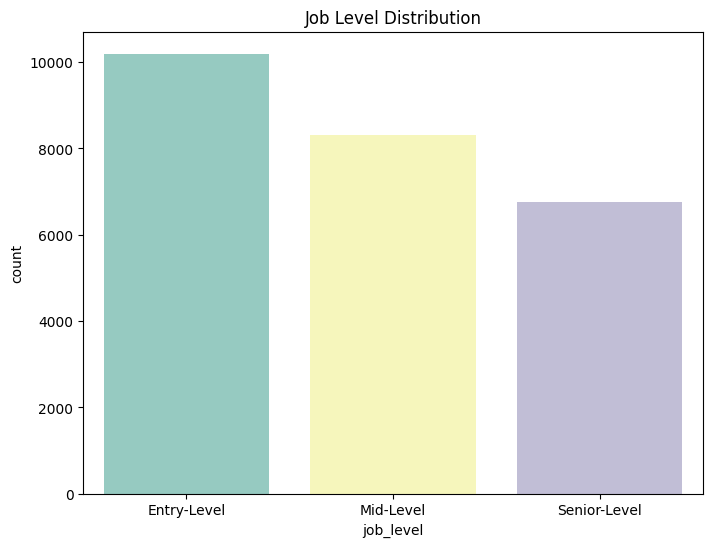

✅ All preprocessing completed.


In [13]:
# Visualization
plt.figure(figsize=(8, 6))
sns.countplot(x='job_level', data=career_data, palette='Set3')
plt.title("Job Level Distribution")
plt.show()

print("All preprocessing completed.")

In [ ]:
# Save cleaned dataset
career_data.to_csv("dataset/datacleanJobstreet.csv", index=False)

In [ ]:
import pandas as pd
import numpy as np
import joblib
from sentence_transformers import SentenceTransformer

# 1. Load job data
career_df = pd.read_csv("dataset/datacleanJobstreet.csv")
career_df["job_title"] = career_df["job_title"].fillna("")
career_df["descriptions"] = career_df["descriptions"].fillna("")
career_df["combined_text"] = career_df["job_title"] + " " + career_df["descriptions"]

# 2. Load BERT embedding model
model = SentenceTransformer("paraphrase-MiniLM-L6-v2")

# 3. Generate embeddings
career_embeddings = model.encode(career_df["combined_text"].tolist(), convert_to_tensor=False)

# 4. Save everything
np.save("career_embeddings.npy", career_embeddings)
joblib.dump(model, "bert_embedder.joblib")
career_df.to_csv("dataset/datacleanJobstreet.csv", index=False)

print(" BERT embeddings saved to career_embeddings.npy")


✅ BERT embeddings saved to career_embeddings.npy
